l'objectif de cette partie est d'extraire les zones à risques d'innodation à partir du fichier shapefile Georisques 


EPSG:4326
Index(['typ_inond1', 'typ_inond2', 'scenario', 'datfinval', 'id_tri',
       'urlrapport', 'est_synth', 'datappro', 'id_carte', 'id', 'geometry'],
      dtype='object')
  typ_inond1 typ_inond2 scenario datfinval           id_tri  \
0         03         03     None       NaT  FRM_TRI_MAYOTTE   
1         02       None    01For       NaT     FRI_TRI_BASS   
2         02       None    01For       NaT     FRI_TRI_BASS   
3         02       None    02Moy       NaT     FRI_TRI_BASS   
4         02       None    02Moy       NaT     FRI_TRI_BASS   

              urlrapport  est_synth   datappro    id_carte    id  \
0  N_MAYO_RISQUES_03.pdf          1 2019-12-16  CSI_030002  9794   
1         non communiqué          0        NaT    CSI_1981  9835   
2         non communiqué          0        NaT    CSI_1982  9836   
3         non communiqué          0        NaT    CSI_1983  9837   
4         non communiqué          0        NaT    CSI_1984  9838   

                                 

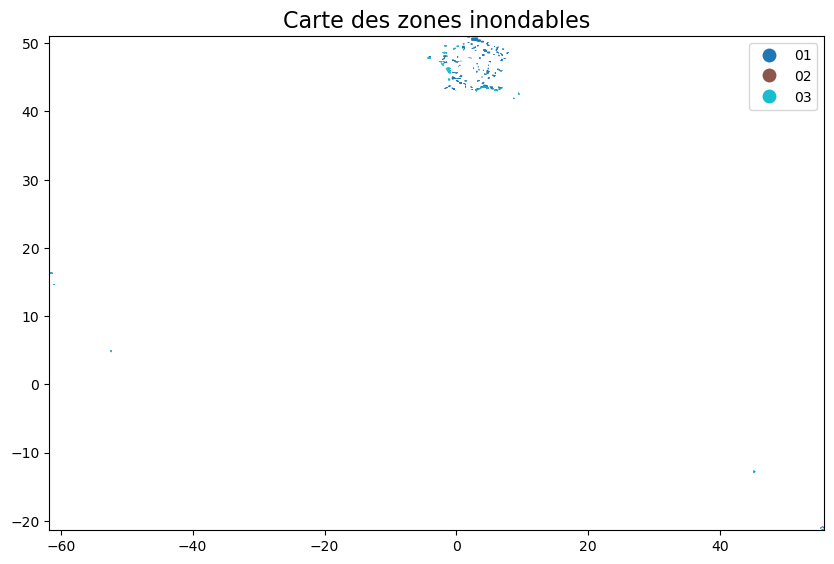

In [3]:
import geopandas as gpd

# 1. Charger le fichier Shapefile (modifiez le chemin vers votre fichier)
shapefile_path = "/home/onyxia/work/Python-For-Data-Science-Project/Shapefile processing/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.crs)


# 2. Afficher un aperçu des colonnes disponibles
print(gdf.columns)

# 3. Afficher un aperçu des données
print(gdf.head())

xmin, ymin, xmax, ymax = gdf.total_bounds
print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # Modifier la taille pour plus de lisibilité

gdf.plot(column='typ_inond1', legend=True, ax=ax)
ax.set_xlim([xmin, xmax])  # Remplacer xmin et xmax par les coordonnées de votre région
ax.set_ylim([ymin, ymax])
plt.title("Carte des zones inondables", fontsize=16)
plt.show()


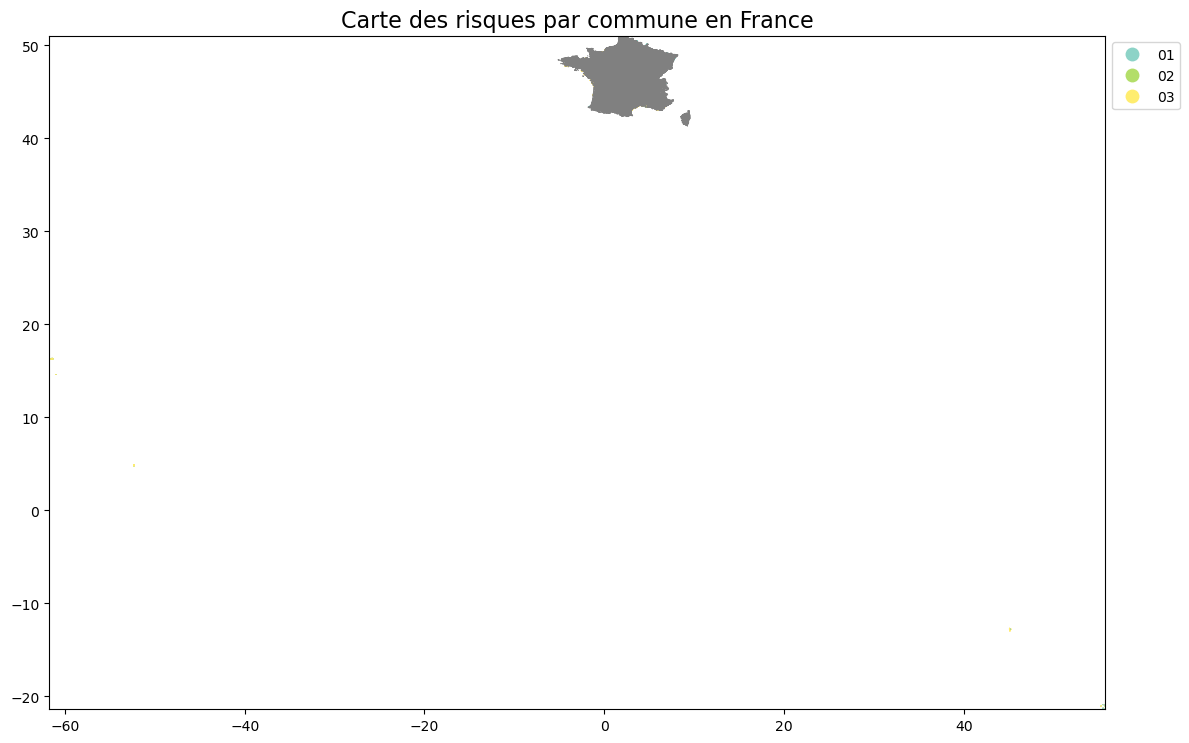

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Télécharger les données Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer pour ne garder que les communes métropolitaines
france = france.loc[france["INSEE_REG"] > 10]

# Charger le Shapefile
shapefile_path = "/home/onyxia/work/Python-For-Data-Science-Project/Shapefile processing/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Vérifier et aligner le CRS
if gdf.crs != france.crs:
    gdf = gdf.to_crs(france.crs)

# Corriger les géométries si nécessaire
gdf["geometry"] = gdf["geometry"].buffer(0)

# Effectuer une jointure spatiale
geo_risks = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(12, 15))

# Afficher les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray")

# Remplir les communes avec des couleurs basées sur les risques
geo_risks.plot(
    column='typ_inond1',  # Colonne contenant les types de risques
    ax=ax,
    legend=True,
    cmap="Set3",
    legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
)

# Ajuster les limites
xmin, ymin, xmax, ymax = geo_risks.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Ajouter un titre
plt.title("Carte des risques par commune en France", fontsize=16)
plt.tight_layout()

# Afficher la carte
plt.show()


In [9]:
geo_risks.columns

Index(['typ_inond1', 'typ_inond2', 'scenario', 'datfinval', 'id_tri',
       'urlrapport', 'est_synth', 'datappro', 'id_carte', 'id', 'geometry',
       'index_right', 'INSEE_DEP', 'INSEE_REG', 'ID', 'NOM', 'INSEE_COM',
       'STATUT', 'POPULATION', 'AREA', 'ARR', 'CV', 'EPCI', 'NATURE_EPCI',
       'ZE2020', 'UU2020', 'TUU2017', 'TDUU2017', 'AAV2020', 'TAAV2017',
       'TDAAV2017', 'CATEAAV2020', 'BV2012', 'LIBELLE_DEPARTEMENT',
       'LIBELLE_REGION', 'PAYS', 'SOURCE'],
      dtype='object')